# Esercizio 5 - Topic Modeling

In questo esercizio si fa uso della libreria *Gensim* per fare il topic modeling, sfruttando il modello **Latent Dirichlet Allocation**
(LDA). E' un modello *non supervisionato* in quanto non necessita di un dataset annotato per fare il training, il che lo rende estremamente versatile e facile da utilizzare.

Un topic è un insieme di keyword dominanti, rappresentative del topic.

**I fattori chiave per ottenere buoni argomenti:**
- La qualità dell'elaborazione del testo
- La varietà di argomenti di cui parla il testo
- La scelta dell'algoritmo di modellazione degli argomenti
- Il numero di argomenti da fornire all'algoritmo
- I parametri di regolazione dell'algoritmo

### Imports

In [17]:
import re
import pandas as pd
from pprint import pprint

# Gensim
import gensim
from gensim.utils import simple_preprocess

# spacy for lemmatization
import spacy

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

from gensim.models.ldamodel import LdaModel

## Dataset

Il dataset è stato estratto da kaggle, e so chiama *"20-Newsgroups"* (https://www.kaggle.com/datasets/crawford/20-newsgroups). Contiene circa 18mila news, divise su 20 argomenti diversi.

In [18]:
df = pd.read_json('../data/tm_data.json')

In [35]:
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [36]:
print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


In [19]:
data = []
for content in df['content']:
    data.append(content)

### Pre-Procesing dei dati

In [20]:
cleaned_data = []

for line in data:
        line = line.lower()
        line = re.sub('\S*@\S*\s?', '', line) #remove e-mails
        line = re.sub('\s+', ' ', line) #remove new lines
        line = re.sub("\'", '', line) #remove single quotes
        cleaned_data.append(line.strip())

In [21]:
def split_sentence(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))    

words1 = list(split_sentence(cleaned_data))

### Realizzazione di **bigrammi** e **trigrammi** (usati dal modello di Gensim)


**bigtrammi** --> Coppia di parole che compaiono spesso assieme nel documento

**trigrammi** --> Triple parole che compaiono spesso assieme nel documento

In [22]:
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS

bigram = gensim.models.Phrases(words1, min_count=5, threshold=100, 
                              connector_words=ENGLISH_CONNECTOR_WORDS)

trigram = gensim.models.Phrases(bigram[words1], threshold=100, 
                               connector_words=ENGLISH_CONNECTOR_WORDS)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


In [23]:
def remove_stopwords(text):
    return [[w for w in simple_preprocess(str(content)) if w not in stopwords] for content in text]

def build_bigrams(text):
    return [bigram_mod[content] for content in text]

def build_trigrams(text):
    return [trigram_mod[bigram_mod[content]] for content in text]

def lemmatizer(text, pos=['NOUN', 'ADJ', 'VERB', 'ADV']):
    output = []
    for s in text:
        content = nlp(" ".join(s)) 
        output.append([tkn.lemma_ for tkn in content if tkn.pos_ in pos])
    return output

In [24]:
words_cleaned = remove_stopwords(words1)
words_bigrams = build_bigrams(words_cleaned)
words_trigrams = build_trigrams(words_cleaned)

### Lemmatizzazione

In [25]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [26]:
lemmatization = lemmatizer(words_bigrams, pos=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(lemmatization[0])

['thing', 'subject', 'car', 'nntp_poste', 'host', 'rac_wam', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']


### Vettori

Trasformiamo i termini in vettori per poterli maneggiare con più semplicità in Gensim

I due elementi principali di cui ha bisogno il modello LDA sono il **corpus** e il **dictionary**, andiamo a costruire il dizionario.

Gensim crea un id unico per ogni parola nel documento. Dopo di crea una lista di coppie **(word_id, word_frequency)**

In [27]:
common_dictionary = Dictionary(lemmatization)
#common_dictionary = Dictionary(words_cleaned)

common_corpus = [common_dictionary.doc2bow(text) for text in lemmatization]
#common_corpus = [common_dictionary.doc2bow(text) for text in words_cleaned]

# Gensim crea un id unico per ogni parola nel documento, e ci associa la frequenza di quella parola (word_id, word_frequency)
print(common_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)]


## Modello LDA

Ora che abbiamo i dati ripuliti e trasformati in vettori possiamo procedere con il training del modello.

Vediamo alcuni iperparametri che possono essere utilizzati per il training del modello:

- *alpha* and *eta* --> Vanno ad influenzare la sparità dei topic. Di base sono settati a *1.0/num_topics*
  
- *chunchsize* --> Numero di documenti da analizzare per ogni iterazione
- *update_every* --> Determina la frequenza con cui i parametri del modello devono essere aggiornati
- *passes* --> E' il numero totale di passaggi di addestramento

In [28]:
lda = LdaModel(corpus=common_corpus, id2word=common_dictionary, num_topics=20, per_word_topics=True)

In [29]:
pprint(lda.print_topics())

[(0,
  '0.014*"disease" + 0.013*"patient" + 0.009*"msg" + 0.008*"health" + '
  '0.007*"study" + 0.007*"cause" + 0.006*"food" + 0.006*"syndrome" + '
  '0.006*"treatment" + 0.005*"line"'),
 (1,
  '0.014*"team" + 0.013*"line" + 0.013*"game" + 0.011*"get" + 0.010*"write" + '
  '0.010*"year" + 0.009*"go" + 0.008*"subject" + 0.008*"article" + '
  '0.008*"play"'),
 (2,
  '0.019*"use" + 0.010*"government" + 0.010*"encryption" + 0.008*"right" + '
  '0.008*"ripem" + 0.008*"line" + 0.007*"subject" + 0.007*"state" + '
  '0.006*"key" + 0.006*"write"'),
 (3,
  '0.013*"say" + 0.012*"go" + 0.011*"armenian" + 0.010*"people" + 0.009*"know" '
  '+ 0.008*"get" + 0.008*"time" + 0.007*"take" + 0.007*"see" + 0.006*"pain"'),
 (4,
  '0.011*"entry" + 0.010*"file" + 0.009*"program" + 0.008*"use" + 0.008*"line" '
  '+ 0.007*"space" + 0.007*"year" + 0.005*"section" + 0.005*"first" + '
  '0.004*"source"'),
 (5,
  '0.020*"c" + 0.014*"ax" + 0.008*"turkish" + 0.007*"sc" + 0.006*"line" + '
  '0.005*"write" + 0.005*"com

***Come interpretiamo i risultati?***

Viene restituita una lista di elementi, in cui:
-  il primo corrisponde al numero del topic (da 0 a 19);
- il secondo elemento invece è una lista di parole con un peso associato:
    - il peso corrisponde a quanto quella parola è presente nel topic, e di conseguenza quanta importanza ha nel determinare il topic.

### Visualizzazione dei dati ottenuti con Wordcloud

Viene realizzata una wordcloud per ogni topic, in cui si rappresentano le prime n parole più importanti per quel topic.

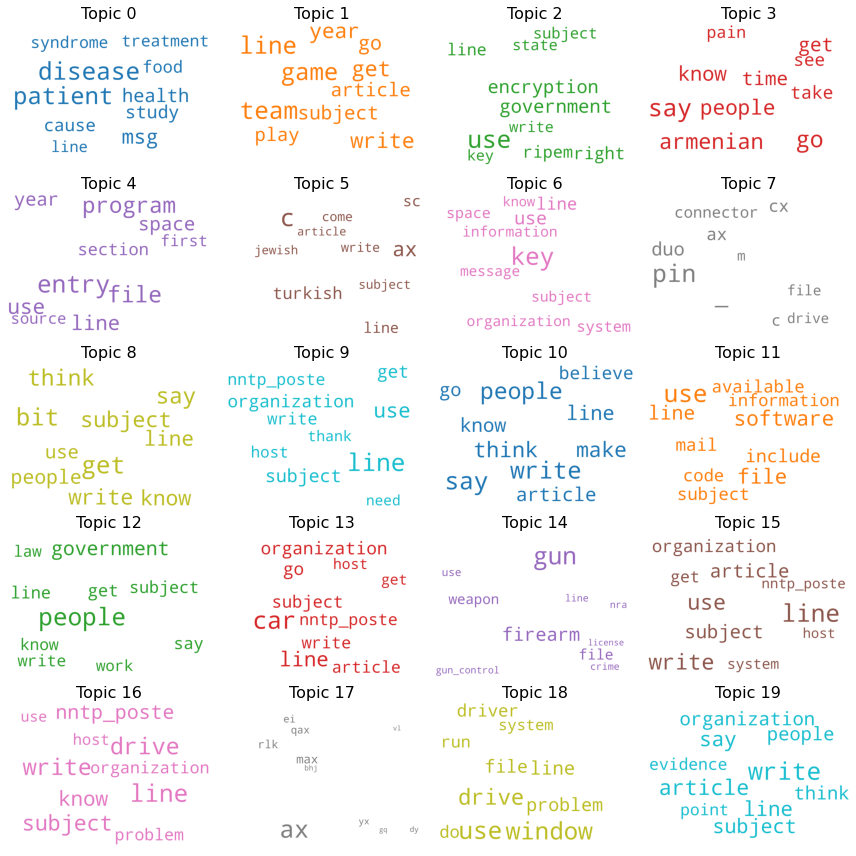

In [30]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab20',
                  color_func=lambda *args, **kwargs: cols[-10+i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False, num_topics=20)

fig, axes = plt.subplots(5, 4, figsize=(12,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()